# Technical lag in Pypi package manager
        Replication study of paper 'Technical Lags of Dependencies in Major Package Managers'. this replication study only
    Pypi package  manager with the recent dataset from library.io

please change your FILE_PATH to your dataset path

In [1]:
import pandas as pd
from enum import Enum
from dataclasses import dataclass
import semver
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tabulate import tabulate
import time


FILE_PATH = ''
Pypi_projects_file = 'pypi_projects-1.6.0.csv'
Pypi_dependencies_file = 'pypi_dependencies-1.6.0_date.csv'
Pypi_versions_file = 'pypi_versions-1.6.0.csv'

# List of project
to check if dependency information exists?

In [2]:
projects = pd.read_csv(FILE_PATH + Pypi_projects_file, low_memory = False)
projects_to_dict = projects.to_dict('records')
projects_list = []
for row in projects_to_dict:
    projects_list.append(row['ID'])
del projects_to_dict
print('Number of projects:', projects.shape[0])
# projects.head()

Number of projects: 231690


# Filtering project pair
    Project pair is the Project A has a dependency on Project B regardless of Project A version, can be classified as follow
    Fixed - allow excatly version of dependency (all dependency of pair have fixed declaration)
    Flexible - allow more than one version of dependency (some dependency of pair have flexible declaration)

    Discard from analysis
    Missing information 
    - some information such as Project ID, time stamp were not available 
    Sub-component 
    - a group of component (first half of name(minimum 4 characters) of  Project A and B are same) may cause inaccurate quantification of lag 
    Not Semantic version 
    - the version that couldn't be parse as Semantic version format, i.e major.minor.micro-tag, and the                              version with large number (maybe timestamp)    
    
    Note: some version number may mix with character can be parsed to semver format by the extract leading digit 
    - ex
        0.0.7dev -> 0.0.7
        4.5.10.15  -> 4.5.10

In [3]:
# Type of pair classification
class Status(Enum):
    FIXED = 1   
    NOT_SV = 2  
    FLEXI = 3   
    SUBCMP = 4   
    MISSING = 5   
    
@dataclass
class ProjectVersion:
    version: str; declaration: str; date_published: str
                
@dataclass
class DependencyVersion:
    version: str; date_published: str
            
@dataclass
class Version:
    version:str ; date_published:str = ''; major: int = 0; minor: int =0; micro: int = 0
    def __post_init__(self):
        v_tok = versionToken(self.version)
        if len(v_tok) > 0:
            self.major = v_tok[0]
        if len(v_tok) > 1:
            self.minor = v_tok[1]
        if len(v_tok) >2:
            self.micro = v_tok[2]
    def semver(self):  #
        return str(self.major) +'.'+ str(self.minor) +'.'+ str(self.micro)

In [4]:
# classify pair to Missing information  Subcomponent  and defult with Fixed
def initPairTest(pair, proj_name, dep_name):
    if pair[1] not in projects_list:
        return Status.MISSING
    first_half = min(len(proj_name)//2, len(dep_name)//2)
    if (first_half > 3) and (proj_name[:first_half] == dep_name[:first_half]) or proj_name == dep_name or pair[0] == pair[1]:
        return Status.SUBCMP
    return Status.FIXED
###

def separateDeclaration(dec): #separate a symbol and version 
    index = 0
    for c in dec:
        if c>= '0' and c<='9':
            break
        elif c == '.':
            return   dec[:index], '0'+dec[index:].strip()
        index += 1
    return dec[:index], dec[index:].strip()

#return verion_token token[0] = major, token[1] = minor, token[2] = micro 
def versionToken(ver: str):
    #trim the declaration symbol
    decSymbol, v = separateDeclaration(ver)
    v_tok = []
    while(len(v)!=0):
        digit = ''
        for c in v:
            if c >= '0' and c <= '9':
                digit += c
            else:
                break
        if digit != '':
            v_tok.append(int(digit))
        else:
            break
        v = v[len(digit)+1:]
    return v_tok

# check that ,is semver violate? (version number is large)
def violateSemver(ver):
    ver_tok = versionToken(ver)
    for tok in ver_tok:
        if tok > 10000:
            return True
    return len(ver_tok) < 1


def declarationClassify(dec):
    dec = dec.strip()
    if re.match('\*', dec):
        return 'any'
    elif re.match('(\<|\<\=)\s*(\d.+|\d)\,(\>\=|\>)\s*(\d.+|\d)', dec):
        return 'range'
    elif re.match('(>)(=|)\s*((\d.+)|(\d))',dec): 
        return 'atleast'
    elif re.match('(<)(=|)\s*((\d.+)|(\d))', dec):
        return 'atmost'
    elif re.match('(~=)\s*((\d.\d.\d))', dec):
        return 'micro'
    elif re.match('(~=)\s*((\d.\d)|(\d))', dec):
        return 'minor'
    elif re.match('(==|)\s*((\d.+)|(\d))',dec) or re.match('\s*((\d.+)|\d)', dec):
        return 'fixed'
    else:
        return 'unclassified'
    

In [5]:
dependencies_df = pd.read_csv(FILE_PATH + Pypi_dependencies_file, 
                           usecols = ['Project ID', 'Version Number', 'Dependency Project ID', 'Dependency Requirements', 'Project Name', 'Dependency Name', 'Published Timestamp']
                          )
dependencies_df = dependencies_df.fillna(0).astype({'Dependency Project ID':int})#.set_index(['Project ID', 'Dependency Project ID']).sort_index()
print('total dependencies:', dependencies_df.shape[0])

total dependencies: 2018154


In [6]:

start = time.perf_counter()

# deps_to_dict = dependencies.to_dict('records')
check_NOT_SV = []
pairs_status= {} # dict key =  (Project ID, Dependency ID) ; value = status
# index = 0
exclude_index = []
# flexi_pair = []

for index, dependency in enumerate(dependencies_df.to_dict('records')): 
    proj_id = dependency['Project ID']; dep_id = dependency['Dependency Project ID']  
    proj_name = dependency['Project Name'];  proj_ver = dependency['Version Number']; dep_dec = dependency['Dependency Requirements']
    dep_name = dependency['Dependency Name']
    pair = (proj_id, dep_id)
    status: Status

    if (pair[0], pair[1]) in pairs_status:
        status = pairs_status[(pair[0], pair[1])]
    else:
        status = initPairTest(pair, proj_name, dep_name) # MISSING SUBCMP  default FIXED


    if status.value < Status.FLEXI.value: 
        if declarationClassify(dep_dec) != 'fixed':
            status = Status.FLEXI
        elif status == Status.FIXED and (violateSemver(proj_ver) or violateSemver(dep_dec)):
            status = Status.NOT_SV
            check_NOT_SV.append((pair, proj_name, proj_ver,dep_name, dep_dec))
    # If one version of dependency have classify as subcomponent or missing we would not classify again    
    pairs_status[(pair[0], pair[1])] = status
#         if status == Status.FLEXI:
#             flexi_index.append(index)
    if status.value > Status.FLEXI.value or status == Status.NOT_SV:# MISSING SUBCMP NOT_SV will be removed from dataset
        exclude_index.append(index)
        
    
        
# del deps_to_dict

stop = time.perf_counter()
print('time spend: ', stop-start, 'seconds')


time spend:  134.0901146 seconds


In [7]:
NOT_SV_pairs = []
FIXED_pairs = []
FLEXI_pairs = []
SUBCMP_pairs = []
MISSING_pairs = []

for p in pairs_status:
    status = pairs_status[p]
    if status == Status.NOT_SV:
        NOT_SV_pairs.append(p)
    elif status == Status.FIXED:
        FIXED_pairs.append(p)
    elif status == Status.FLEXI:
        FLEXI_pairs.append(p)
    elif status == Status.SUBCMP:
        SUBCMP_pairs.append(p)
    elif status == Status.MISSING:
        MISSING_pairs.append(p)

print('Classification of Pair of project')
print(tabulate([
    ['FIXED', 'FLEXI', 'NOT_SV', 'SUBCMP','MISSING'],
    [len(FIXED_pairs), len(FLEXI_pairs), len(NOT_SV_pairs), len(SUBCMP_pairs), len(MISSING_pairs)]
],headers = 'firstrow', tablefmt = 'fancy_grid'))



Classification of Pair of project
╒═════════╤═════════╤══════════╤══════════╤═══════════╕
│   FIXED │   FLEXI │   NOT_SV │   SUBCMP │   MISSING │
╞═════════╪═════════╪══════════╪══════════╪═══════════╡
│   19455 │  125653 │      122 │     7459 │      1707 │
╘═════════╧═════════╧══════════╧══════════╧═══════════╛


In [8]:
dependencies_df.set_index(['Project ID', 'Dependency Project ID'], inplace = True)
dependencies_df.drop( NOT_SV_pairs+SUBCMP_pairs+MISSING_pairs, axis = 0, inplace = True)
dependencies_df.reset_index(inplace = True)
print('dependencies after filtering: ', dependencies_df.shape[0])

dependencies after filtering:  1887689


# List of versions
    a dictionary that contains list versions and published timestamp of each project
    

In [9]:

#verlist = pd.read_sql('SELECT projectid, number, publishedtimestamp FROM versions', connect)
verlist = pd.read_csv(FILE_PATH + Pypi_versions_file, usecols = ['Project ID', 'Number', 'Published Timestamp'])
Verlist_dict = {}
for r in verlist.to_dict('records'):
    projid = r['Project ID']
    if projid not in Verlist_dict:
        Verlist_dict[projid] = []
    Verlist_dict[projid].append(Version(r['Number'], r['Published Timestamp']))

verlist.head()
 

,Project ID,Number,Published Timestamp
0,31611,1.0.0,2013-01-11 15:08:35 UTC
1,31612,0.1.0,2014-09-04 15:06:46 UTC
2,31612,1.0.0,2014-09-04 15:11:43 UTC
3,31613,0.1.2,2013-02-19 15:57:47 UTC
4,31613,0.1.3,2013-02-19 16:02:01 UTC


# Quantification lag
    in this study, lag identify to two types. version lag and time lag
    Method 
    - choose the dependency versions available before Project was published
    - sort dependency versions by descending
    - collect the dependency versions that not satisfy with dependency declaration until found the satisfying dependency version
    - now, we calculate a version lag categorize by major,minor, and micro version from the cpllection of not satisfying dependency version
    - major version lag: the distinct major version later than satisfying dependency version
    - minor version lag: the distinct minor version later than satisfying dependency version, and have same major version with satisfying dependency version
    - micro version lag: the distinct micro version later than satisfying dependency version, and have same major, minor version with satisfying dependency version
    
    Example: 
       Project a has a dependency version 1.0.0, there are available version 1.0.1, 1.0.2, 1.1.0, 1.1.1, 2.0.0, 2.0.1, 2.1.0
        major lag: 1 -> 2.0.0
        minor lag: 1 -> 1.1.0
        micro lag: 2 -> 1.0.1, 1.0.2
    
    
    For time lag quantify by the period between the published time stamp of project and published timestamp of first newer version dependency
    Example:
        major time lag: -> published time stamp of Project - published time stamp of 2.0.0
        minor time lag: -> published time stamp of Project - published time stamp of 1.1.0
        micro time lag: -> published time stamp of Project - published time stamp of 1.0.1
        
    Historys of dependency have been counted
    
    And we classify type of lag into major, major&minor, major&micro, major&minor&micro, minor, minor & micro, and micro
   

In [10]:
def declarationSemver(dec, dec_type): #return declaration following semver grammar for use in function semver.match
    dec_symbol, dec_version = separateDeclaration(dec)
    dec_semver = Version(dec_version.strip()).semver()
    if dec_type == 'atmost' or dec_type == 'atleast':
        return dec_symbol.strip() + dec_semver.strip()
    elif dec_type == 'fixed':
        if len(dec_symbol) == 0:
            dec_symbol = '=='
        return dec_symbol.strip() + dec_semver.strip()
    elif dec_type == 'range':
        decs = dec.split(',')
        list_dec = []
        for d in decs:
            dec_symbol, dec_version = separateDeclaration(d)
            dec_semver = Version(dec_version.strip()).semver()
            list_dec.append(dec_symbol.strip() + dec_semver.strip())
        return list_dec
    elif dec_type == 'micro':
        most = semver.bump_minor(dec_semver)
        return ['>=' + dec_semver, '<'+ most]
    elif dec_type == 'minor':
        most = semver.bump_major(dec_semver)
        return ['>=' + dec_semver, '<'+ most]
    else:
        return None

def declarationMatch(dep_ver, dec, dec_type): #return bool that dependency version is satisfy the dependency declaration and classification
    if dec_type == 'any':
        return True
    
    dep_semver = Version(dep_ver).semver()
    if dec_type == 'atmost' or dec_type == 'atleast':
        return semver.match(dep_semver, dec)
    elif dec_type == 'fixed':      
        return semver.match(dep_semver, dec)        
    elif dec_type == 'range':
        is_match = True
        for d in dec:
            is_match &= semver.match(dep_semver, d)
        return is_match
    elif dec_type == 'micro':
        is_match = True
        for d in dec:
            is_match &= semver.match(dep_semver, d)
        return is_match
    elif dec_type == 'minor':
        is_match = True
        for d in dec:
            is_match &= semver.match(dep_semver, d)
        return is_match
    return False
    
def daylag(proj_date, min_miss_dep_date): # time in day duration of Project and the first newer dependencies
    return(datetime.strptime(proj_date, '%Y-%m-%d %H:%M:%S UTC') - datetime.strptime(min_miss_dep_date, '%Y-%m-%d %H:%M:%S UTC')).days

#Calculate technical lag major; minor; micro; Version   major; minor; micro; Time
def lagCal(versions_not_match , version_match: DependencyVersion, proj: ProjectVersion):
    lag = [0,0,0,0,0,0]
    versions_not_match.sort(key= lambda x: (x.major, x.minor, x.micro))
    major_miss = []
    minor_miss = []
    micro_miss = []
    
    Bdep = version_match
    Bref = Version('0.0.0')
    for ver in versions_not_match:
        Bi = ver
        if Bi.major == Bdep.major:
            if Bi.minor == Bdep.minor and Bi.micro > Bref.micro:
                micro_miss.append(ver)
            elif Bi.minor > Bdep.minor and Bi.minor > Bref.minor:
                minor_miss.append(ver)
        elif Bi.major > Bdep.major and Bi.major > Bref.major:
            major_miss.append(ver)
        Bref = Bi
    
    major_miss_len = len(major_miss)
    minor_miss_len = len(minor_miss)
    micro_miss_len = len(micro_miss)
    lag[0] = major_miss_len
    lag[1] = minor_miss_len
    lag[2] = micro_miss_len
    if major_miss_len != 0:
        lag[3] = daylag(proj.date_published, min(major_miss, key= lambda v: v.date_published).date_published)
    if minor_miss_len != 0:
        lag[4] = daylag(proj.date_published, min(minor_miss, key= lambda v: v.date_published).date_published)
    if micro_miss_len != 0:
        lag[5] = daylag(proj.date_published, min(micro_miss, key= lambda v: v.date_published).date_published)
    
    return tuple(lag)
    
    
def classifyLag(lag):
    res = ''
    if lag[0] > 0:
        res += 'MAJOR'
    if lag[1] > 0:
        res += 'MINOR'
    if lag[2] > 0:
        res += 'MICRO'
    if len(res) >0:
        return res
    else:
        return 'NOLAG'
            

In [11]:
start = time.perf_counter()
lagType = [] #collect the lag type
lags = [] #collect the lag value
classifications = [] #collect the declaration classification

for r in dependencies_df.to_dict('records'): # for each dependency
    
    pair = (r['Project ID'], r['Dependency Project ID'])
    
    
    proj = ProjectVersion(r['Version Number'], r['Dependency Requirements'], r['Published Timestamp'])
    classification = declarationClassify(proj.declaration)
    try: 
        dep_histrory = Verlist_dict[pair[1]]
    except: # some miss information of dependency in versions dataset 
        classification == 'unclassified'
    
    lag = (0,0,0,0,0,0)
    # unclassification type will be removed
    if classification == 'unclassified':
        lagType.append(classification)
        classifications.append(classification)
        lags.append(lag)
        continue    
        
    # dependency published before project  release    
    published_deps = [d for d in dep_histrory if d.date_published < proj.date_published] 
    published_deps.sort(key = lambda x: (x.major, x.minor, x.micro), reverse = True) 
    
    declaration = declarationSemver(proj.declaration, classification)
    versions_not_match = []
    version_match = None
    lag_type ='NOLAG'            
    for d in published_deps:
        if declarationMatch(d.version, declaration, classification): # found the satisfying version then calculate lag 
            version_match = Version(d.version, d.date_published)
            lag = lagCal(versions_not_match, version_match, proj)
            lag_type = classifyLag(lag)            
            break
        else:
            versions_not_match.append(d) # collect the version doesn't satisfy the declaration
    
    lags.append(lag)
    lagType.append(lag_type)
    classifications.append(classification)
    


stop  = time.perf_counter()
print('time spend:', stop-start, 'seconds')
    


time spend: 243.12944199999998 seconds


Add declaration classifications, lag types , and lags to dataframe

In [12]:
dependencies_df['classification'] = classifications
dependencies_df['lagtype'] = lagType
dependencies_df['majorlag'] = [l[0] for l in lags]
dependencies_df['minorlag'] = [l[1] for l in lags]
dependencies_df['microlag'] = [l[2] for l in lags]
dependencies_df['majortimelag'] = [l[3] for l in lags]
dependencies_df['minortimelag'] = [l[4] for l in lags]
dependencies_df['microtimelag'] = [l[5] for l in lags]

dependencies_df = dependencies_df[dependencies_df['classification'] != 'unclassified' ]
print('the remaining dependencies: ', dependencies_df.shape[0])
dependencies_df.head()

the remaining dependencies:  1887271


,Project ID,Dependency Project ID,Project Name,Version Number,Dependency Name,Dependency Requirements,Published Timestamp,classification,lagtype,majorlag,minorlag,microlag,majortimelag,minortimelag,microtimelag
0,31613,68140,1pass,0.1.2,pycrypto,*,2013-02-19 15:57:47 UTC,any,NOLAG,0,0,0,0,0,0
1,31613,68140,1pass,0.1.3,PyCrypto,*,2013-02-19 16:02:01 UTC,any,NOLAG,0,0,0,0,0,0
2,31613,68140,1pass,0.1.5,PyCrypto,*,2013-03-03 18:21:08 UTC,any,NOLAG,0,0,0,0,0,0
3,31613,68140,1pass,0.1.6,PyCrypto,*,2013-03-21 06:36:41 UTC,any,NOLAG,0,0,0,0,0,0
4,31613,68140,1pass,0.1.7,PyCrypto,*,2013-04-17 06:26:16 UTC,any,NOLAG,0,0,0,0,0,0


# Technical lag in version and time
        model of technical lag catagorize by major, minor, and micro, a lag value 0 have been excluded, to show amount, 
    and prevalence of technical lag
    

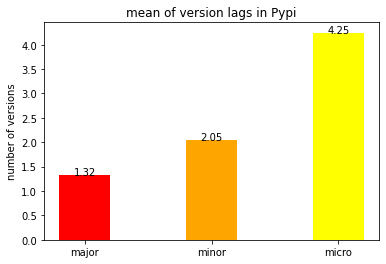

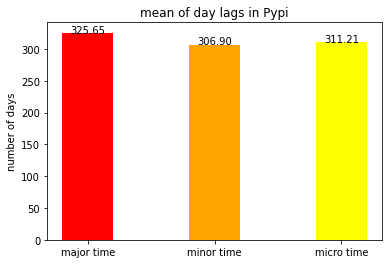

In [13]:
plt.figure()
color = ['red','orange', 'yellow']

ver_lags_mean = [np.array([l[0] for l in lags if l[0] > 0]).mean(), 
                np.array([l[1] for l in lags if l[1] > 0]).mean(),
                np.array([l[2] for l in lags if l[2] > 0]).mean()]
ver_lag = ['major', 'minor', 'micro']
ypos = np.arange(len(ver_lag))
plt.xticks(ypos, ver_lag)
plt.ylabel('number of versions')
plt.title('mean of version lags in Pypi')
plt.bar(ypos, ver_lags_mean, color = color, width = 0.4)
for i, lag_mean in enumerate(ver_lags_mean):
    plt.text(i, lag_mean, "{:.2f}".format(lag_mean), ha = 'center')

plt.figure()
time_lags_mean = [np.array([l[3] for l in lags if l[3] > 0]).mean(),
                np.array([l[4] for l in lags if l[4] > 0]).mean(),
                np.array([l[5] for l in lags if l[5] > 0]).mean()]
time_lag = ['major time', 'minor time', 'micro time']
ypost = np.arange(len(time_lag))
plt.xticks(ypost, time_lag)
plt.ylabel('number of days')
plt.title('mean of day lags in Pypi')
plt.bar(ypost, time_lags_mean, color = color, width = 0.4)
for i, lag_mean in enumerate(time_lags_mean):
    plt.text(i, lag_mean, "{:.2f}".format(lag_mean), ha = 'center')

Distribution of lag


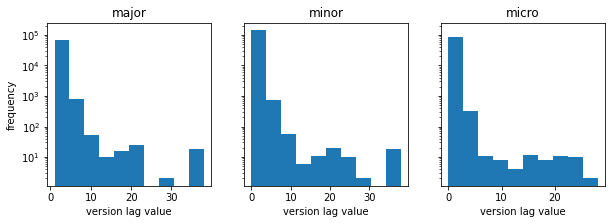

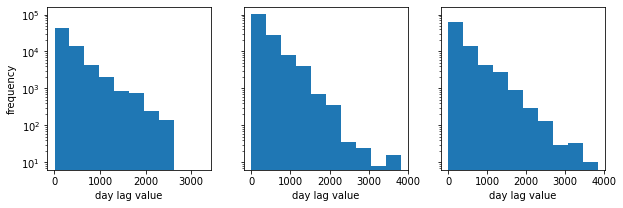

In [14]:
print('Distribution of lag')
fig, ax = plt.subplots(1,3, sharey = True, figsize = (10,3))

ax[0].set_yscale('log')
ax[0].set_ylabel('frequency')
for i, v in enumerate(['major', 'minor', 'micro']):
    ax[i].hist([l[0] for l in lags if l[i] > 0]) 
    ax[i].set_title(v)
    ax[i].set_xlabel('version lag value')


fig2, ax2 = plt.subplots(1,3, sharey = True, figsize = (10,3))
ax2[0].set_yscale('log')
ax2[0].set_ylabel('frequency')
for i, v in enumerate(['major', 'minor', 'micro']):
    ax2[i].hist([l[i+3] for l in lags if l[i+3] > 0])
    ax2[i].set_xlabel('day lag value')

plt.show()

Typically, the lag is small amount. 

# Percentage of lag dependencies  
        since the version range declaration is the main source of technical lag, we would consider Percentage of 
    dependencies that lag categorize by version range declaration.

In [15]:
depslag = dependencies_df.groupby(['classification', 'lagtype' ]).count()['Project ID']
dectype = ['fixed', 'micro', 'minor','atmost','range']
print(' Percentage of dependencies that lag categorize by declaration ')
print(tabulate([
    ['Fixed', 'Micro', 'Minor', 'At-Most','Range', 'Overall'],
    ["{:.1f}".format(depslag[dt].drop('NOLAG').sum()/depslag[dt].sum()*100) if dt in depslag else '-' for dt in dectype] 
     + ["{:.1f}".format(depslag.drop('NOLAG', level = 1).sum()/depslag.drop(['any', 'atleast']).sum()*100)]
    
],headers = 'firstrow', tablefmt = 'fancy_grid'))
print('Any and At-least should not induce lag')
print(tabulate([
    ['Any', 'At-least'],
    ["{:.1f}".format(depslag['any'].drop('NOLAG').sum()/depslag['any'].sum()*100),
     "{:.1f}".format(depslag['atleast'].drop('NOLAG').sum()/depslag['atleast'].sum()*100)
    ]
],headers = 'firstrow', tablefmt = 'fancy_grid'))

 Percentage of dependencies that lag categorize by declaration 
╒═════════╤═════════╤═════════╤═══════════╤═════════╤═══════════╕
│   Fixed │ Micro   │ Minor   │   At-Most │   Range │   Overall │
╞═════════╪═════════╪═════════╪═══════════╪═════════╪═══════════╡
│    49.7 │ -       │ -       │      58.4 │    26.6 │        45 │
╘═════════╧═════════╧═════════╧═══════════╧═════════╧═══════════╛
Any and At-least should not induce lag
╒═══════╤════════════╕
│   Any │   At-least │
╞═══════╪════════════╡
│     0 │          0 │
╘═══════╧════════════╛


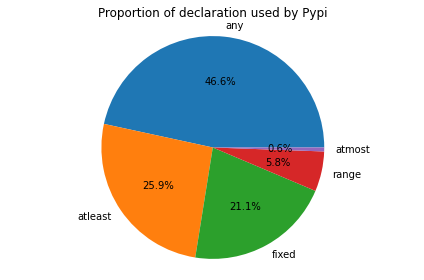

In [16]:
decla = dependencies_df.classification.value_counts()

plt.pie([d for d in decla], labels = [dec for dec in decla.keys()], autopct = '%0.1f%%', radius = 2)
plt.axis('equal')
plt.title('Proportion of declaration used by Pypi')
plt.tight_layout()

plt.show()

fixed declaration is the main cause of inducing technical lag

# Proportion of type lag
    


In [24]:
lagtype = dependencies_df.lagtype.value_counts(normalize = True).mul(100).round(1)

fig =go.Figure(go.Sunburst(
    labels=['Total', 'No lag', 'Major lag', 'Major', 'Major & minor', 'Major & micro', 'Major & Minor & Micro', 'Minor lag', 'Minor',
           'Minor & Micro', 'Micro lag', 'Micro'],
    parents=['', 'Total', 'Total', 'Major lag', 'Major lag', 'Major lag', 'Major lag', 'Total', 'Minor lag', 'Minor lag', 'Total', 'Micro lag'],
    values=[ lagtype.sum(), lagtype['NOLAG'], lagtype[['MAJOR', 'MAJORMINOR', 'MAJORMICRO', 'MAJORMINORMICRO']].sum(),
            lagtype['MAJOR'], lagtype['MAJORMINOR'], lagtype['MAJORMICRO'], lagtype['MAJORMINORMICRO'],
            lagtype[['MINOR','MINORMICRO']].sum(), lagtype['MINOR'], lagtype['MINORMICRO'],
            lagtype['MICRO'], lagtype['MICRO']
           ],
    branchvalues="total",
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

# Update VS LAG 
        fixed declaration is the main cause of lag, we would study, do developers regulary update their declaration on the        fixed  pair of project, how regularly they update?, and do they change declaration to avoid from lag?
        
        Methode:
            compare the declaration between two of pair of projects version contiguously release
        

In [18]:
dependencies_df.set_index(['Project ID', 'Dependency Project ID'], inplace = True)
fixed_df = dependencies_df.loc[FIXED_pairs]
fixed_df.reset_index(inplace = True)
fixed_df.sort_values(by =['Project ID', 'Dependency Project ID', 'Published Timestamp'], ascending= True, inplace = True)
# fixed_df.set_index(['Project ID', 'Dependency Project ID'], inplace = True)
print('total of fixed dependencies in fixed pair:', fixed_df.shape[0])

total of fixed dependencies in fixed pair: 300624


In [19]:
def classifyDeclarationChange(ver1, ver2):
    if ver2.major > ver1.major:
        return 'FORWARDMAJOR'
    elif ver2.major < ver1.major:
        return 'BACKWARDMAJOR'
    if ver2.minor > ver1.minor:
        return 'FORWARDMINOR'
    elif ver2.minor < ver1.minor:
        return 'BACKWARDMINOR'
    if ver2.micro > ver1.micro:
        return 'FORWARDMICRO'
    elif ver2.micro < ver1.micro:
        return 'BACKWARDMICRO'
    return  'NOCHANGE'


In [20]:
pair = (0, 0)
last_dec = None
last_version = None

decChangeTypes = []
projChangeTypes = []

for r in fixed_df.to_dict('records'):
    cur_dec = Version(r['Dependency Requirements'])
    cur_version = Version(r['Version Number'])
    if (r['Project ID'] != pair[0] or r['Dependency Project ID'] != pair[1]): # new pair
        pair = (r['Project ID'], r['Dependency Project ID'])
        last_dec = cur_dec
        last_version = cur_version
        decChangeTypes.append('NOCHANGE')
        projChangeTypes.append('NOCHANGE')
        continue
    decChangeTypes.append(classifyDeclarationChange(last_dec, cur_dec))
    projChangeTypes.append(classifyDeclarationChange(last_version, cur_version))
    last_dec = cur_dec
    last_version = cur_version
    


In [21]:
fixed_df['versionChange'] = projChangeTypes
fixed_df['declarationChange'] = decChangeTypes
updateVsLag = fixed_df.groupby(['declarationChange', 'lagtype']).count()
updateVsLag = updateVsLag['Project ID']
fixed_df.head()

,Project ID,Dependency Project ID,Project Name,Version Number,Dependency Name,Dependency Requirements,Published Timestamp,classification,lagtype,majorlag,minorlag,microlag,majortimelag,minortimelag,microtimelag,versionChange,declarationChange
0,31620,66294,2mp4,0.1.5,progressbar,==2.2,2014-10-20 00:56:04 UTC,fixed,NOLAG,0,0,0,0,0,0,NOCHANGE,NOCHANGE
1,31620,66294,2mp4,0.1.5.1,progressbar,==2.2,2014-10-20 01:17:39 UTC,fixed,NOLAG,0,0,0,0,0,0,NOCHANGE,NOCHANGE
2,31792,1172727,adrest,2.1.12,python-mimeparse,==0.1.4,2013-04-26 08:19:04 UTC,fixed,NOLAG,0,0,0,0,0,0,NOCHANGE,NOCHANGE
3,31792,1172727,adrest,2.1.13,python-mimeparse,==0.1.4,2013-04-27 03:22:53 UTC,fixed,NOLAG,0,0,0,0,0,0,FORWARDMICRO,NOCHANGE
4,31792,1172727,adrest,2.1.14,python-mimeparse,==0.1.4,2013-04-27 05:49:39 UTC,fixed,NOLAG,0,0,0,0,0,0,FORWARDMICRO,NOCHANGE


In [22]:
LAG = ['MAJOR', 'MAJORMICRO', 'MAJORMINOR', 'MAJORMINORMICRO', 'MICRO', 'MINOR', 'MINORMICRO']
LAG_MAJOR_CURENT = ['MICRO', 'MINOR', 'MINORMICRO']
MAJOR_CURENT = ['MAJOR', 'MAJORMICRO', 'MAJORMINOR', 'MAJORMINORMICRO', 'NOLAG']
UPDATE = ['BACKWARDMAJOR', 'BACKWARDMINOR', 'BACKWARDMICRO','FORWARDMAJOR','FORWARDMICRO','FORWARDMINOR']


total = updateVsLag.sum()
print('Update vs Lag')
print(tabulate([
    ['Updated & Outdated', 'No Update & Outdated', 'Updated & Current', 'No Update & Current'],
    ["{:.1f}".format(updateVsLag.drop(labels = 'NOCHANGE',errors = 'ignore').drop(labels = 'NOLAG' , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = UPDATE ,errors = 'ignore').drop(labels = 'NOLAG' , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = 'NOCHANGE',errors = 'ignore').drop(labels = LAG , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = UPDATE,errors = 'ignore').drop(labels = LAG , level = 1,errors = 'ignore').sum()/total *100)
    ]
], headers = 'firstrow', tablefmt= 'fancy_grid'))

print('Update vs Lag (allow major lag as current)')
print(tabulate([
    ['Updated & Outdated', 'No Update & Outdated', 'Updated & Current', 'No Update & Current'],
    ["{:.1f}".format(updateVsLag.drop(labels = 'NOCHANGE',errors = 'ignore').drop(labels = MAJOR_CURENT , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = UPDATE ,errors = 'ignore').drop(labels = MAJOR_CURENT , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = 'NOCHANGE',errors = 'ignore').drop(labels = LAG_MAJOR_CURENT , level = 1,errors = 'ignore').sum()/total *100),
     "{:.1f}".format(updateVsLag.drop(labels = UPDATE,errors = 'ignore').drop(labels = LAG_MAJOR_CURENT , level = 1,errors = 'ignore').sum()/total *100)
    ]
], headers = 'firstrow', tablefmt= 'fancy_grid'))

Update vs Lag
╒══════════════════════╤════════════════════════╤═════════════════════╤═══════════════════════╕
│   Updated & Outdated │   No Update & Outdated │   Updated & Current │   No Update & Current │
╞══════════════════════╪════════════════════════╪═════════════════════╪═══════════════════════╡
│                  0.6 │                   47.8 │                 1.6 │                    50 │
╘══════════════════════╧════════════════════════╧═════════════════════╧═══════════════════════╛
Update vs Lag (allow major lag as current)
╒══════════════════════╤════════════════════════╤═════════════════════╤═══════════════════════╕
│   Updated & Outdated │   No Update & Outdated │   Updated & Current │   No Update & Current │
╞══════════════════════╪════════════════════════╪═════════════════════╪═══════════════════════╡
│                  0.5 │                   35.7 │                 1.7 │                    62 │
╘══════════════════════╧════════════════════════╧═════════════════════╧════════